In [3]:
# Load data
df = pd.read_excel("c:\\Users\\MMP\\Desktop\\data_science\\CLV_project_5\\online_retail_II.xlsx")


In [4]:
import pandas as pd

df = pd.read_excel("C:\\Users\\MMP\\Desktop\\data_science\\CLV_project_5\\online_retail_II.xlsx", engine='openpyxl')


In [6]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


# 1. Data Cleaning
# This script cleans the data by removing rows with missing values and duplicates.
Removing or correcting inaccurate, missing, or irrelevant data (e.g., null Customer ID, negative Quantity, canceled invoices).


Importance.
Ensures data quality and accuracy.
Prevents misleading results during analysis.
Improves model performance if you're building predictive models.
Eliminates outliers and inconsistent records (like returns or missing values).

In [11]:
# Remove rows with missing Customer ID
df = df.dropna(subset=["Customer ID"])

# Remove cancelled transactions (if 'Invoice' starts with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove rows with negative quantity or price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Add total price
df['TotalPrice'] = df['Quantity'] * df['Price']


2_Descriptive sale analysis
#explore the data to understand the sales trends and patterns.
Basic summary of sales performance — total revenue, top-selling products, sales by month/country, etc.



Importance.
Gives a clear overview of your business.
Identifies best-selling products and top revenue-generating countries.
Highlights seasonal trends and sales growth over time.
Helps you make data-driven decisions (e.g., increase inventory for top products, target best-performing countries).

In [12]:
# Total revenue
total_revenue = df['TotalPrice'].sum()

# Top 10 selling products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Monthly sales trend
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('InvoiceMonth')['TotalPrice'].sum()

# Sales by country
sales_by_country = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)


3. Customer Segmentation with RFM Analysis
# This script performs RFM analysis to segment customers based on their purchasing behavior.
# RFM stands for Recency, Frequency, and Monetary value.
A method to evaluate customer value based on:
Recency: How recently a customer made a purchase
Frequency: How often they purchased
Monetary: How much they spent

Importance.
Helps in customer segmentation (e.g., loyal customers, at-risk customers)
Optimizes marketing efforts by targeting specific customer groups
Improves customer retention strategies
Supports personalization (e.g., send discount emails to recent frequent buyers)

In [13]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']


 4. Customer Lifetime Value (CLV) Modeling
Estimates how much revenue a customer will bring during their relationship with your business.

Identify your most valuable customers
Focus marketing on high-value segments
Predict future revenue

In [17]:
# Keep only customers with:
# - frequency > 0
# - monetary_value > 0
summary_filtered = summary[(summary['frequency'] > 0) & (summary['monetary_value'] > 0)]


In [18]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter()
ggf.fit(summary_filtered['frequency'], summary_filtered['monetary_value'])


<lifetimes.GammaGammaFitter: fitted with 2818 subjects, p: 2.21, q: 3.62, v: 501.98>

In [19]:
# Predict expected average profit
summary_filtered['predicted_monetary'] = ggf.conditional_expected_average_profit(
    summary_filtered['frequency'],
    summary_filtered['monetary_value']
)

# Predict CLV (e.g., over 6 months)
summary_filtered['CLV'] = ggf.customer_lifetime_value(
    bgf,  # previously fitted BG/NBD model
    summary_filtered['frequency'],
    summary_filtered['recency'],
    summary_filtered['T'],
    summary_filtered['monetary_value'],
    time=6,
    discount_rate=0.01
)

# Show top customers by CLV
print(summary_filtered[['frequency', 'monetary_value', 'predicted_monetary', 'CLV']].sort_values('CLV', ascending=False).head(10))


             frequency  monetary_value  predicted_monetary            CLV
Customer ID                                                              
18102.0           42.0     8259.002619         8043.319950  132965.347547
14646.0           45.0     5393.010222         5265.091449   93096.586883
14156.0           78.0     2506.409487         2475.126575   74689.398547
14911.0          127.0     1192.235748         1185.096540   57812.343201
13694.0           48.0     2685.693750         2630.999079   49767.354951
17511.0           24.0     3393.022083         3252.835146   31371.696895
16754.0           18.0     3505.892778         3314.879698   30916.905960
15061.0           40.0     2000.241000         1954.704256   30808.960551
16684.0           18.0     4407.782778         4160.901918   30803.516880
17949.0           42.0     1386.942857         1360.394142   22515.448930


In [21]:
# Use only filtered data for CLV modeling
ggf.fit(summary_filtered['frequency'], summary_filtered['monetary_value'])

# Predict CLV only for filtered customers
summary_filtered['CLV'] = ggf.customer_lifetime_value(
    bgf,
    summary_filtered['frequency'],
    summary_filtered['recency'],
    summary_filtered['T'],
    summary_filtered['monetary_value'],
    time=6,
    discount_rate=0.01
)

# View top customers by CLV
print(summary_filtered[['CLV']].sort_values(by='CLV', ascending=False).head())


                       CLV
Customer ID               
18102.0      132965.347547
14646.0       93096.586883
14156.0       74689.398547
14911.0       57812.343201
13694.0       49767.354951


#store the results back into the summary table
# Importance.
# Provides insights into customer profitability
# Helps in budgeting and forecasting

In [22]:
# Safely merge CLV values back into the main summary table
summary = summary.merge(summary_filtered[['CLV']], how='left', left_index=True, right_index=True)
# Fill NaN values in CLV with 0
summary['CLV'] = summary['CLV'].fillna(0)

#CLV dashboard
# Visualize key metrics and trends related to customer lifetime value.
Top customers by CLV
Predicted future purchases
CLV distribution
Monetary value vs frequency
Filters for time periods or countries (optional)



In [24]:
pip install dash

   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.9 MB ? eta -:--:--
   --- ------------------------------------ 0.8/7.9 MB 1.3 MB/s eta 0:00:06
   ----- ---------------------------------- 1.0/7.9 MB 1.5 MB/s eta 0:00:05
   ------ --------------------------------- 1.3/7.9 MB 1.5 MB/s eta 0:00:05
   --------- ------------------------------ 1.8/7.9 MB 1.7 MB/s eta 0:00:04
   ---------- ----------------------------- 2.1/7.9 MB 1.6 MB/s eta 0:00:04
   ------------- -------------------------- 2.6/7.9 MB 1.7 MB/s eta 0:00:04
   --------------- ------------------------ 3.1/7.9 MB 1.8 MB/s eta 0:00:03
   ------------------ --------------------- 3.7/7.9 MB 1.9 MB/s eta 0:00:03
   ------------------- -------------------- 3.9/7.9 MB 1.8 MB/s eta 0:00:03
   --------------------- ---------------

In [27]:
# 1. Imports
import pandas as pd
import dash
from dash import dcc, html
import plotly.express as px
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data

# 2. Load & preprocess your data
df = pd.read_excel("c:\\Users\\MMP\\Desktop\\data_science\\CLV_project_5\\online_retail_II.xlsx")
df.dropna(subset=["Customer ID"], inplace=True)
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]
df['TotalPrice'] = df['Quantity'] * df['Price']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 3. CLV Modeling
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
summary = summary_data_from_transaction_data(
    df, 'Customer ID', 'InvoiceDate', monetary_value_col='TotalPrice', observation_period_end=snapshot_date
)
summary = summary[summary['frequency'] > 0]

bgf = BetaGeoFitter()
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    30, summary['frequency'], summary['recency'], summary['T']
)

ggf = GammaGammaFitter()
ggf.fit(summary['frequency'], summary['monetary_value'])
summary['predicted_monetary'] = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])
summary['CLV'] = ggf.customer_lifetime_value(
    bgf, summary['frequency'], summary['recency'], summary['T'], summary['monetary_value'],
    time=6, discount_rate=0.01
)

# 4. Dash App
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Customer Lifetime Value Dashboard", style={'textAlign': 'center'}),

    dcc.Graph(
        id='top-clv-customers',
        figure=px.bar(
            summary.sort_values("CLV", ascending=False).head(10).reset_index(),
            x='Customer ID', y='CLV', title='Top 10 Customers by CLV'
        )
    ),

    dcc.Graph(
        id='clv-distribution',
        figure=px.histogram(summary, x='CLV', nbins=50, title='CLV Distribution')
    ),

    dcc.Graph(
        id='monetary-vs-frequency',
        figure=px.scatter(
            summary, x='frequency', y='monetary_value', size='CLV',
            title='Frequency vs Monetary Value (Bubble size = CLV)'
        )
    )
])

if __name__ == '__main__':
    app.run(debug=True)
    



#5 Interpret and Communicate Results# Summarize findings and insights from the analysis.
# Create visualizations to support your conclusions.
# Importance.
# Helps stakeholders understand the analysis results

In [28]:
summary[['frequency', 'recency', 'T', 'monetary_value', 'predicted_purchases', 'predicted_monetary', 'CLV']].describe()


,frequency,recency,T,monetary_value,predicted_purchases,predicted_monetary,CLV
count,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000,2818.000000
mean,4.502129,205.538325,264.853797,415.410091,0.493899,428.154584,1386.212695
std,6.959299,111.475772,101.380366,453.069984,0.442687,352.089976,3924.892939
min,1.000000,1.000000,7.000000,7.900000,0.042030,43.814285,64.028113
25%,1.000000,113.000000,200.000000,196.471250,0.268758,283.057849,530.003419
50%,3.000000,214.000000,290.000000,311.660000,0.400000,353.302325,813.567312
75%,5.000000,304.000000,360.000000,473.963036,0.578337,457.340747,1306.216530
max,127.000000,373.000000,374.000000,8416.400000,7.986609,8043.319950,126527.004415


In [ ]:
# Define customer segments based on CLV
# Define customer segments
summary['CLV_Segment'] = pd.qcut(summary['CLV'], q=3, labels=['Low', 'Medium', 'High'])

# Count of customers in each segment
print(summary['CLV_Segment'].value_counts())

# Average values by segment
print(summary.groupby('CLV_Segment')[['frequency', 'monetary_value', 'CLV']].mean())


CLV_Segment
High      940
Low       939
Medium    939
Name: count, dtype: int64
             frequency  monetary_value          CLV
CLV_Segment                                        
Low           1.844515      224.332355   428.190325
Medium        3.242812      346.508517   829.566883
High          8.414894      675.112828  2899.269528


High CLV customers purchase more frequently and spend more each time.
Low CLV customers are infrequent or low spenders → might need re-engagement.



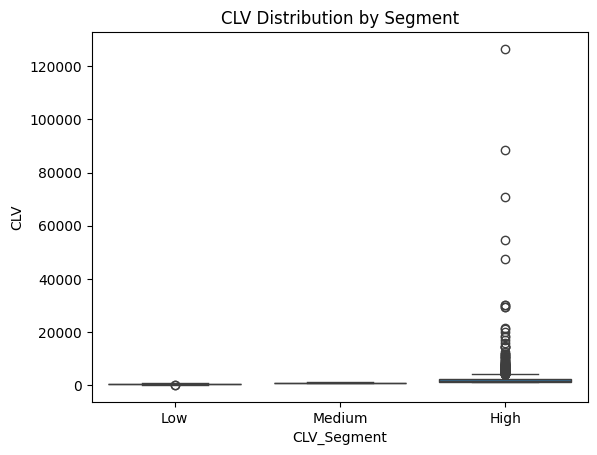

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=summary, x='CLV_Segment', y='CLV')
plt.title('CLV Distribution by Segment')
plt.show()
# Visualize CLV segments
plt.figure(figsize=(10, 6))

The CLV distribution is highly skewed, with a small group of high CLV customers contributing most of the predicted future revenue. Most customers fall into the low to medium CLV range, indicating potential for growth via retention, engagement, and cross-selling. High CLV outliers are key revenue drivers and should be nurtured with personalized strategies.

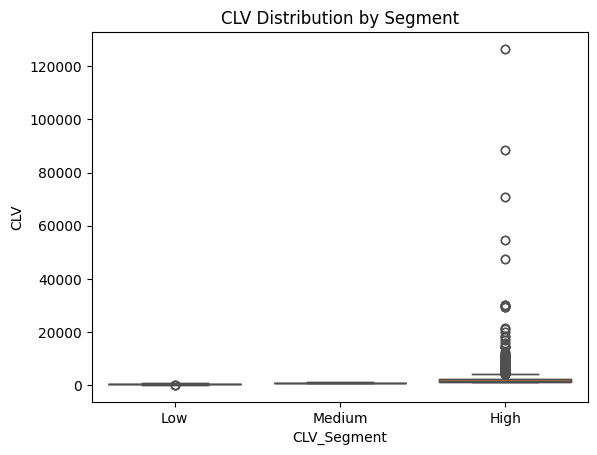

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [31]:
# visualize the distribution of CLV by segment
sns.boxplot(x='CLV_Segment', y='CLV', data=summary)
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=summary, x='CLV_Segment', y='CLV')
plt.title('CLV Distribution by Segment')
plt.show()
# Visualize the distribution of CLV by segment
plt.figure(figsize=(10, 6))

In [32]:
# top customers by CLV
top_customers = summary.sort_values('CLV', ascending=False).head(10)
top_customers = summary.sort_values('CLV', ascending=False).head(10)
print(top_customers[['CLV', 'frequency', 'monetary_value']])
# Visualize top customers by CLV
plt.figure(figsize=(12, 6))

                       CLV  frequency  monetary_value
Customer ID                                          
18102.0      126527.004415       42.0     8259.002619
14646.0       88610.181483       45.0     5393.010222
14156.0       70820.457218       78.0     2506.409487
14911.0       54724.369248      127.0     1192.235748
13694.0       47309.493743       48.0     2685.693750
17511.0       30255.407217       24.0     3393.022083
16684.0       30028.021006       18.0     4407.782778
16754.0       29539.166423       18.0     3505.892778
15061.0       29345.831573       40.0     2000.241000
17949.0       21436.952572       42.0     1386.942857


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Our CLV model, built using the BG/NBD and Gamma-Gamma models, reveals a clear customer value segmentation. The top 10% of customers contribute a disproportionately high share of future revenue. By focusing our retention, marketing, and product efforts on high CLV customers while re-engaging low-value segments, we can improve customer profitability and long-term business growth.